# Linear discriminant analysis
Discriminant analysis is a classification method. If each class density follows a multivariate Gaussian distribution
$$ f_k(x) = \frac{1}{(2\pi)^{p/2} | \Sigma_k |^{1/2}} e^{-\frac{1}{2} (x-\mu_k)^T \Sigma_k^{-1} (x - \mu_k} )$$
Then we want to claasify the observations based on the posterior probability $Pr(G=k|X) $. If we further assume that the classes have a common covariance matrix $\Sigma_k = \Sigma $, then to compare two classes $k$ and $\ell$, it is sufficient to look at the log-ratios
$$ \log \frac{Pr(G=k| X = x)}{Pr(G = \ell |X = x)} = \log(\pi_k/\pi_\ell) - 1/2(\mu_k + \mu_\ell)^T \Sigma^{-1} (\mu_k - \mu_\ell) + x^T \Sigma^{-1}(\mu_k - \mu_\ell) $$
Thus we have the __linear discriminant functions__
$$ \delta_k(x) = x^T \Sigma^{-1}\mu_k - (1/2)\mu_k \Sigma^{-1} \mu_k + \log \pi_k $$

To estimate the paramters, we have
$$ \hat{\pi}_k = N_k /N $$
$$ \hat{\mu}_k = \sum_{g_i = k} x_i / N_k $$
$$ \hat{\Sigma} = \sum_{k = 1}^K \sum_{g_i = k} (x_i - \hat{\mu}_k)(x_i - \hat{\mu}_k)^T/(N - K) $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/Users/apple/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


The source code of the implementation is as follows:

In [2]:
class LinearDiscriminant(object):
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        
        Labels = np.unique(y)
        
        classNum = len(Labels) # K
        
        mu = np.zeros((classNum, X.shape[1])) # Vector of mu_k
        Pi = np.zeros(classNum) # Vector of pi_k
        Sigma = np.zeros((X.shape[1], X.shape[1])) # 
        
        Ntot = len(y)
        
        for k in range(len(Labels)):
            Lab = Labels[k]
            
            indLab = y == Lab
            Pi[k] = np.sum(indLab)/(Ntot + 0.0)
            
            Xlab = X[y == Lab]
            
            mu[k] = Xlab.mean(axis = 0)
            
            Sigma = Sigma + np.dot((Xlab - mu[k]).T, (Xlab - mu[k]))
            
        Sigma = Sigma / (Ntot - classNum)
            
        self.mu = mu
        self.Pi = Pi
        self.Sigma = Sigma
        self.Precision = np.linalg.inv(Sigma)
        self.Labels = Labels
        self.classNum = classNum
        
    def calLogProb(self, X):
        logProb = np.zeros((X.shape[0], self.classNum))
        
        logProb = (X.dot(np.dot(self.Precision, self.mu.T)) -
        0.5*np.diagonal(np.dot(self.mu, np.dot(self.Precision, self.mu.T))) + np.log(self.Pi))
        
        return logProb

    def predict(self, X):
        y = np.array(self.Labels[0] * X.shape[0])
        
        logProb = self.calLogProb(X)
        
        predLabels = self.Labels[np.argmax(logProb, axis = 1)]
        
        return predLabels

We can generate the simulated data as follows:

In [3]:
sigma = 0.5
np.random.seed(123)
# First class: center (-1, -1)
x1x = np.random.normal(-1, sigma, 500)
x1y = np.random.normal(-1, sigma, 500)
X1 = np.vstack((x1x, x1y)).T
y1 = np.array([1]*500)

# Second class: center (1, 1)
x2x = np.random.normal(1, sigma, 1500)
x2y = np.random.normal(1, sigma, 1500)
X2 = np.vstack((x2x, x2y)).T
y2 = np.array([2]*1500)

X = np.vstack((X1, X2))
y = np.concatenate((y1, y2))

So the simulated data consist of two groups of proportion 1/3 and 2/3 with stand deviation diag(0.5, 0.5). The means of the two groups are (-1, -1) and (1, 1). We can have a look at the first 3 observations from group 1.

In [4]:
X1[:3]

array([[-1.5428153 , -0.62398317],
       [-0.50132728, -0.96517963],
       [-0.85851075, -1.13272281]])

They can be plotted as

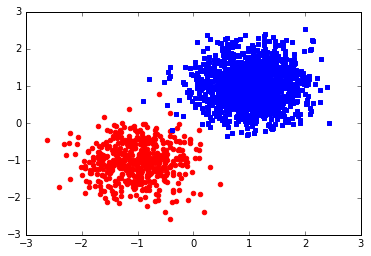

In [5]:
plt.scatter(x1x, x1y, color = 'r', marker = 'o')
plt.scatter(x2x, x2y, color = 'b', marker = 's')
plt.show()

Now we proceed to estimate the parameters of the simulated data distributioin.

In [6]:
ldis = LinearDiscriminant()
ldis.fit(X, y)

The estimated parameters are

In [7]:
ldis.classNum

2

In [8]:
ldis.Sigma

array([[ 0.23646446,  0.00498746],
       [ 0.00498746,  0.24687092]])

The above parameter estimation seems to coincide well with the parameters used to generate the data. Now we test the classifier on a set of test data

In [9]:
# Generate test data
np.random.seed(52)
x3x = np.random.normal(-1, sigma, 30)
x3y = np.random.normal(-1, sigma, 30)
X3 = np.vstack((x3x, x3y)).T

x4x = np.random.normal(1, sigma, 90)
x4y = np.random.normal(1, sigma, 90)
X4 = np.vstack((x4x, x4y)).T

XTest = np.vstack((X3, X4))
yTest = np.concatenate((np.array([1]*30), np.array([2]*90)))

predLabels = ldis.predict(XTest)

In [10]:
np.sum(predLabels == 2)

90

To visualize the classifier, we use the function __plot_decision_regions__ by Sebastian Raschka, which can be found in his book *Python Machine Learning* and his package *mlxtend*.

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution = 0.02):
    
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha = 0.4, cmap = cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0], y = X[y == cl, 1],
                   alpha = 0.8, c = cmap(idx),
                   marker = markers[idx], label = cl)

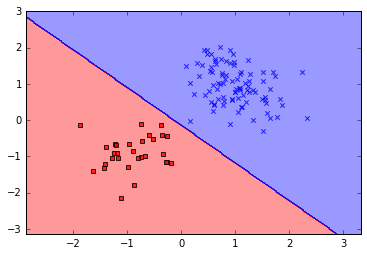

In [12]:
plot_decision_regions(XTest, yTest, ldis)

The theoretical separating plane can be calculated as the line $  x_1 + x_2 = \log(3)/8 $. So we can look the point $(0.06, \log(3)/8)$ and $ (-0.06, \log(3)/8)$, which should be classified into different groups.

In [13]:
ldis.predict(np.array([[0.06, -np.log(2)/8]]))

array([2])

In [14]:
ldis.predict(np.array([[-0.06, -np.log(2)/8]]))

array([1])